In [2]:
# Make own packages auto reload
%load_ext autoreload
%autoreload 2

# Mosaics

In [3]:
from plot import plot_mosaics
from simulate import simulate_rgc_mosaics
import numpy as np

np.random.seed(42)
n_mosaics = 3
center_noise = 0.1  # Position noise
diameter_noise = 0.1

mean_diameters = [10., 12.0, 15.0]  # Mean diameter for each mosaic
n_missing_list = [0, 0, 0]  # Missing cells per mosaic
overlap_factors = [1.1, 1.1, 1.1]  # No overlap, 15% overlap, 10% gaps

# Generate mosaics
groups, polygons, centers, clipped = simulate_rgc_mosaics(
    n_mosaics=n_mosaics,
    mean_diameters=mean_diameters,
    center_noise=center_noise,
    diameter_noise=diameter_noise,
    n_missing_list=n_missing_list,
    overlap_factors=overlap_factors,
)

In [4]:
from overlap import compute_iou_matrix

iou_matrix = compute_iou_matrix(polygons)

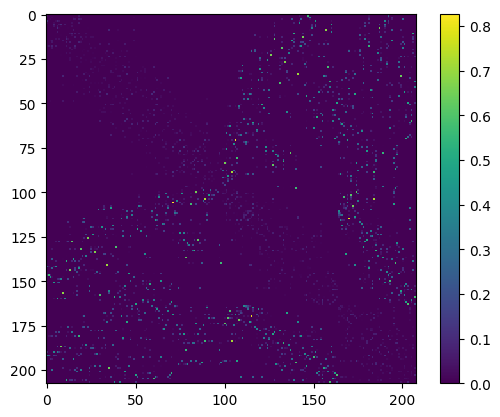

In [5]:
from matplotlib import pyplot as plt

plt.imshow(iou_matrix, interpolation='none')
plt.colorbar()
plt.show()

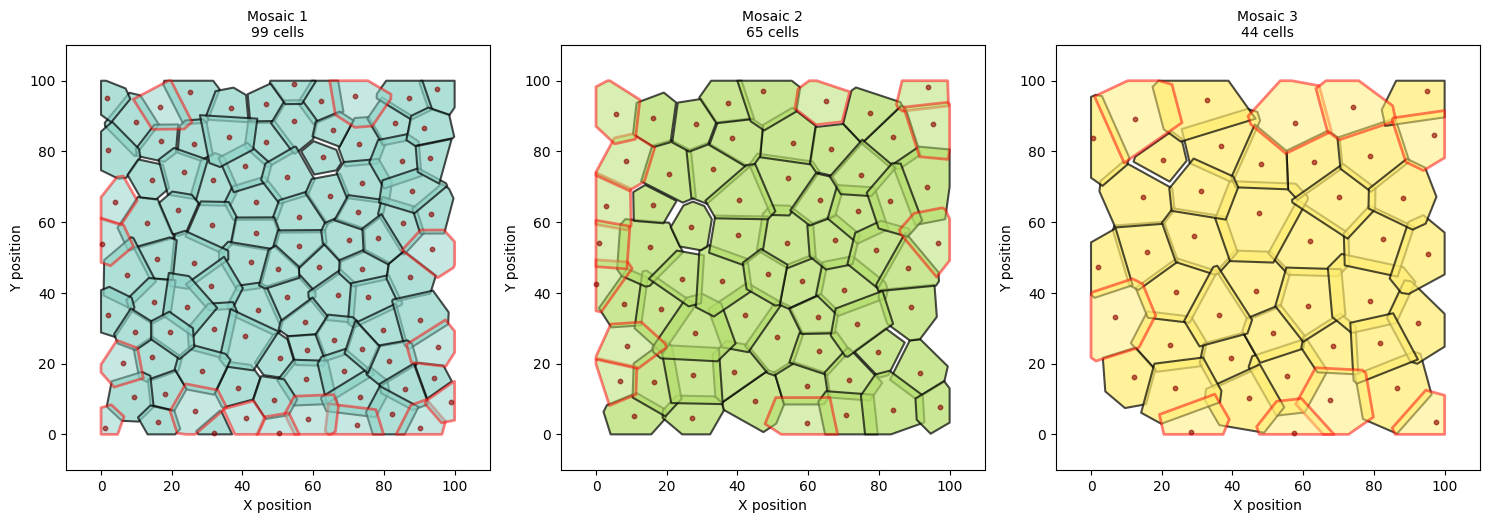

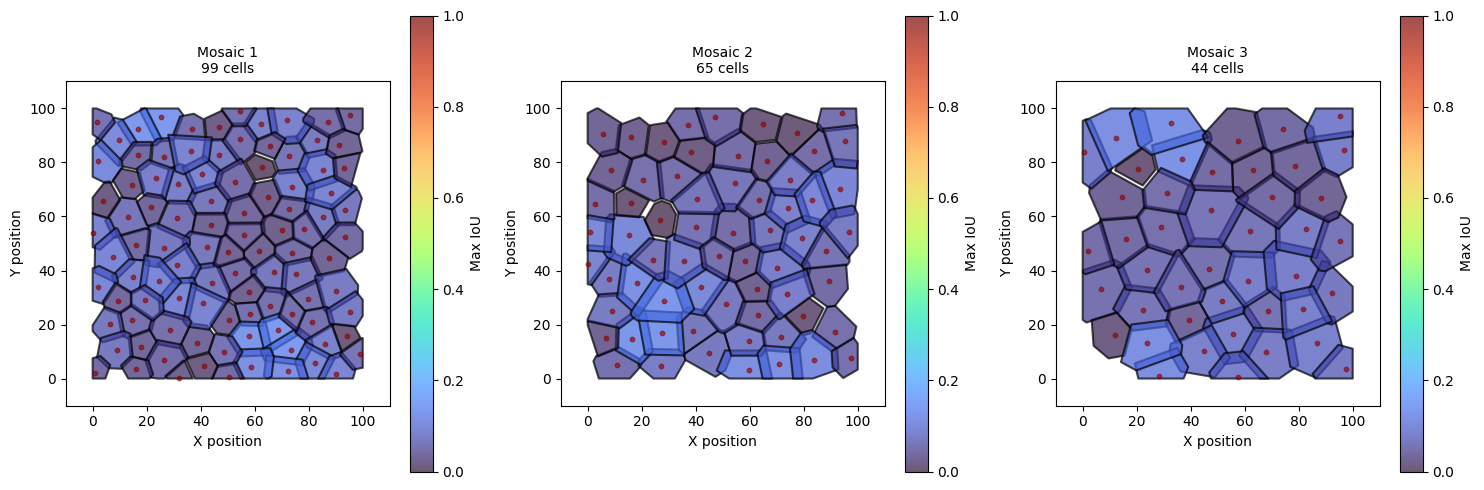

In [6]:
from matplotlib import pyplot as plt

plot_mosaics(groups, polygons, centers, highlight=clipped, mode='basic')
plt.show()

plot_mosaics(groups, polygons, centers, iou_matrix=iou_matrix, highlight=clipped, mode='iou')
plt.show()

# Features

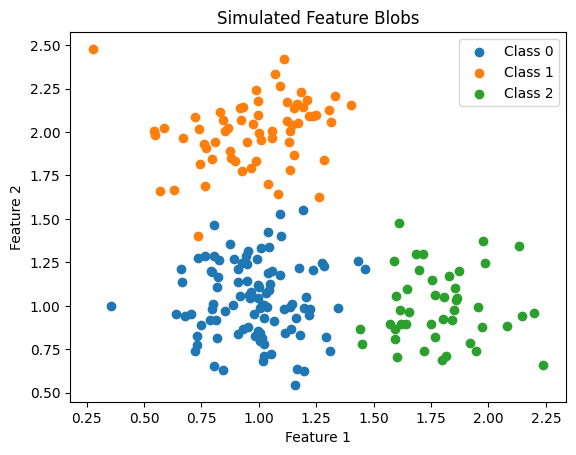

In [7]:
from plot import plot_blobs
from matplotlib import pyplot as plt
import numpy as np

u_groups, n_per_group = np.unique(groups, return_counts=True)
n_groups = len(u_groups)

assert n_groups == 3

feat_centers = [
    (1, 1),
    (1, 2),
    (1.8, 1),
]

feat_stds = [
    (0.2, 0.2),
    (0.2, 0.2),
    (0.2, 0.2),
]

X = []
y = []
for i, n_i in enumerate(n_per_group):
    center_i = feat_centers[i]
    stds_i = feat_stds[i]
    X_i = np.random.normal(center_i, stds_i, size=(n_i, 2))
    X.append(X_i)
    y.append(np.full(n_i, i))

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

plot_blobs(X=X, y=y)

In [8]:
import scanpy as sc

adata = sc.AnnData(X)
sc.pp.scale(adata)
sc.pp.neighbors(adata, n_neighbors=5, use_rep='X')

# Connectivities

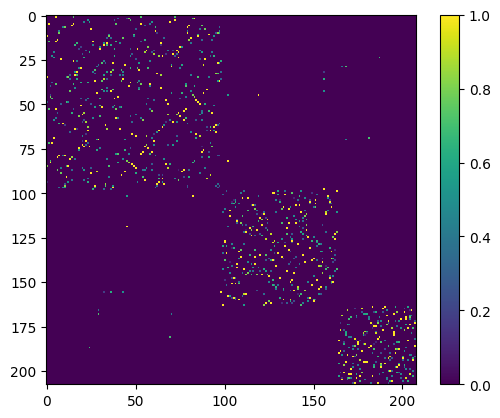

In [9]:
plt.imshow(adata.obsp['connectivities'].toarray(), interpolation='none')
plt.colorbar()
plt.show()

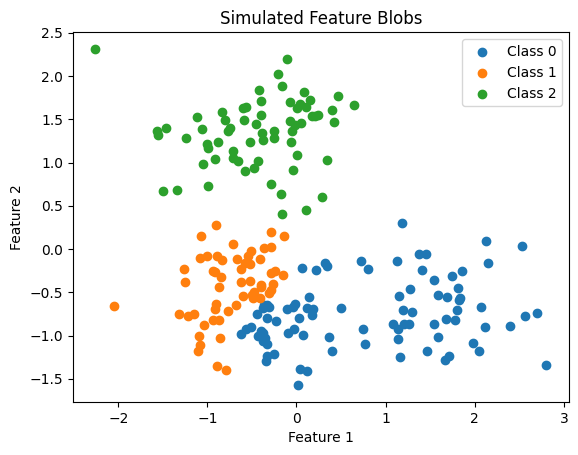

In [10]:
from clustering import find_leiden_resolution

leiden_res = find_leiden_resolution(
    adata, n_groups, adjacency_key='connectivities', key_added='leiden',
    start_res=0.1, tolerance=0, max_iter=20, verbose=False
)
plot_blobs(X=X, y=adata.obs["leiden"])
plt.show()

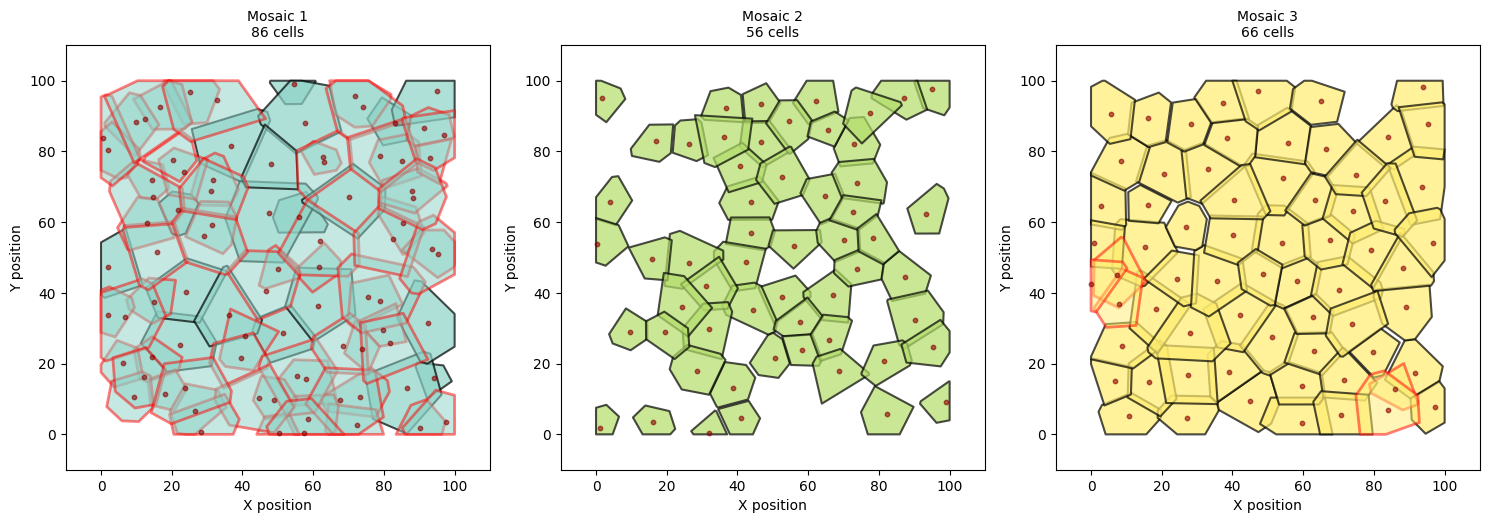

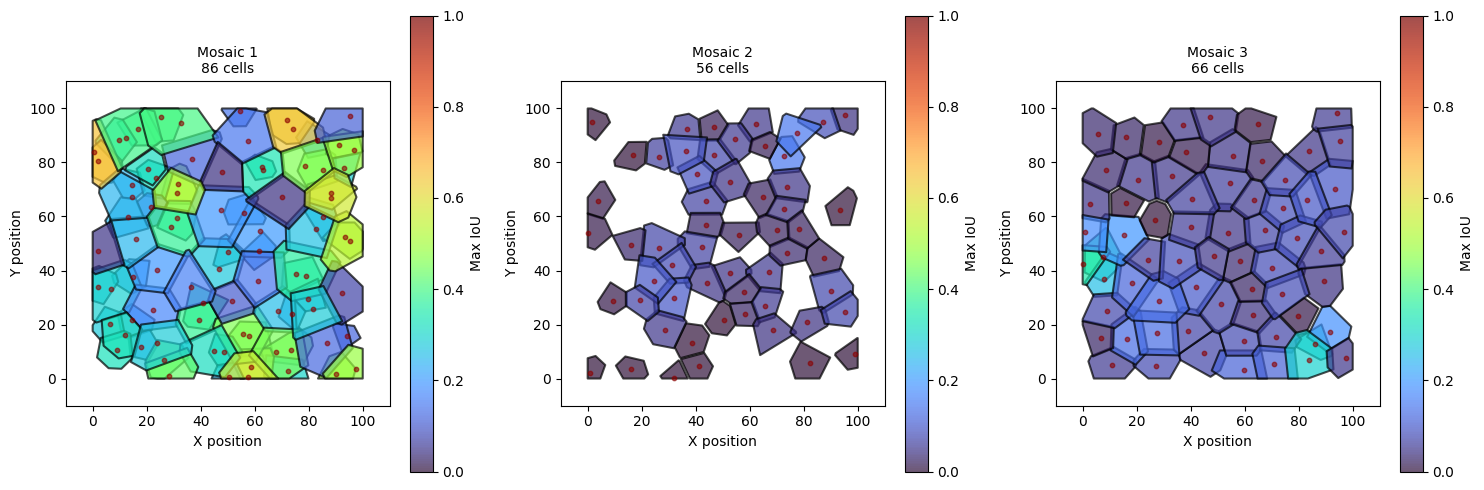

In [11]:
plot_mosaics(adata.obs["leiden"], polygons, centers, mode='violations', iou_matrix=iou_matrix, iou_threshold=0.2)
plt.show()
plot_mosaics(adata.obs["leiden"], polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()

In [12]:
from clustering import apply_mosaic_constraints

repel_threshold = 0.3

# 2. Apply spatial mosaic penalty
adata = apply_mosaic_constraints(
    adata,
    iou_matrix,
    attract_threshold=0.15,
    repel_threshold=repel_threshold,
    attract_weight=2,
    repel_weight=2,
    mode='multiply',
)

In [13]:
diff = adata.obsp['connectivities'].toarray() - adata.obsp['mosaic_connectivities'].toarray()

(diff > 0).sum() / (diff == 0).sum()

np.float64(0.025213270142180094)

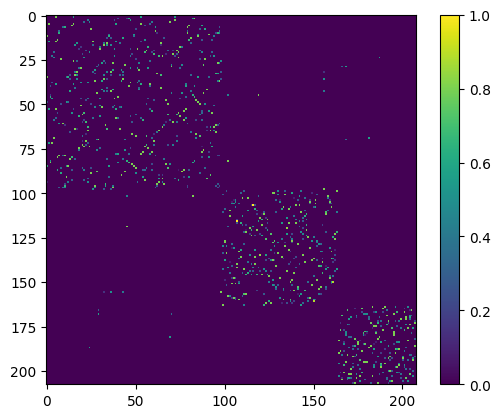

In [14]:
plt.imshow(adata.obsp['mosaic_connectivities'].toarray(), interpolation='none')
plt.colorbar()
plt.show()

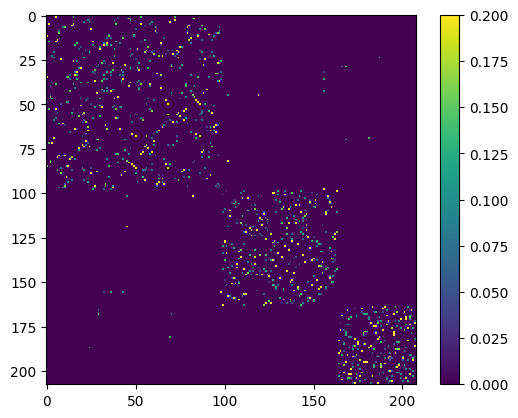

In [15]:
plt.imshow(diff, interpolation='none')
plt.colorbar()
plt.show()

In [16]:
from clustering import find_leiden_resolution

find_leiden_resolution(
    adata, n_groups, adjacency_key='mosaic_connectivities', key_added='leiden_mosaic',
    start_res=leiden_res, tolerance=0, max_iter=20, verbose=False
);

In [17]:
adata.obs["leiden_mosaic"].unique()

['0', '1', '2']
Categories (3, object): ['0', '1', '2']

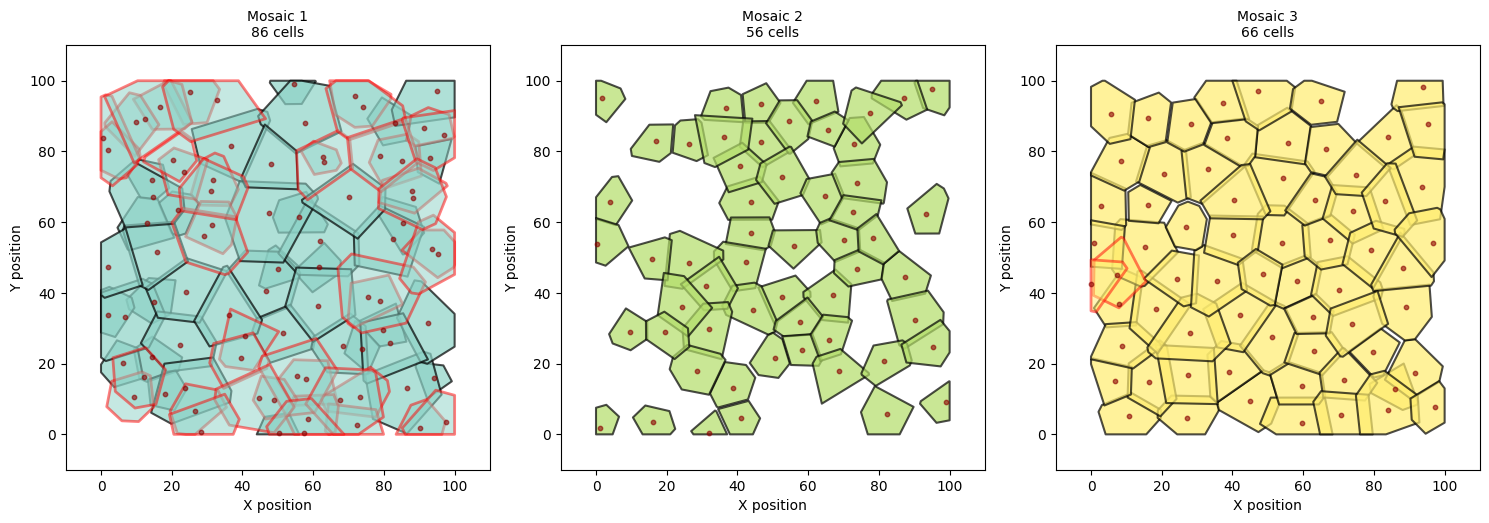

In [18]:
plot_mosaics(adata.obs["leiden"], polygons, centers, mode='violations', iou_matrix=iou_matrix,
             iou_threshold=repel_threshold)
plt.show()

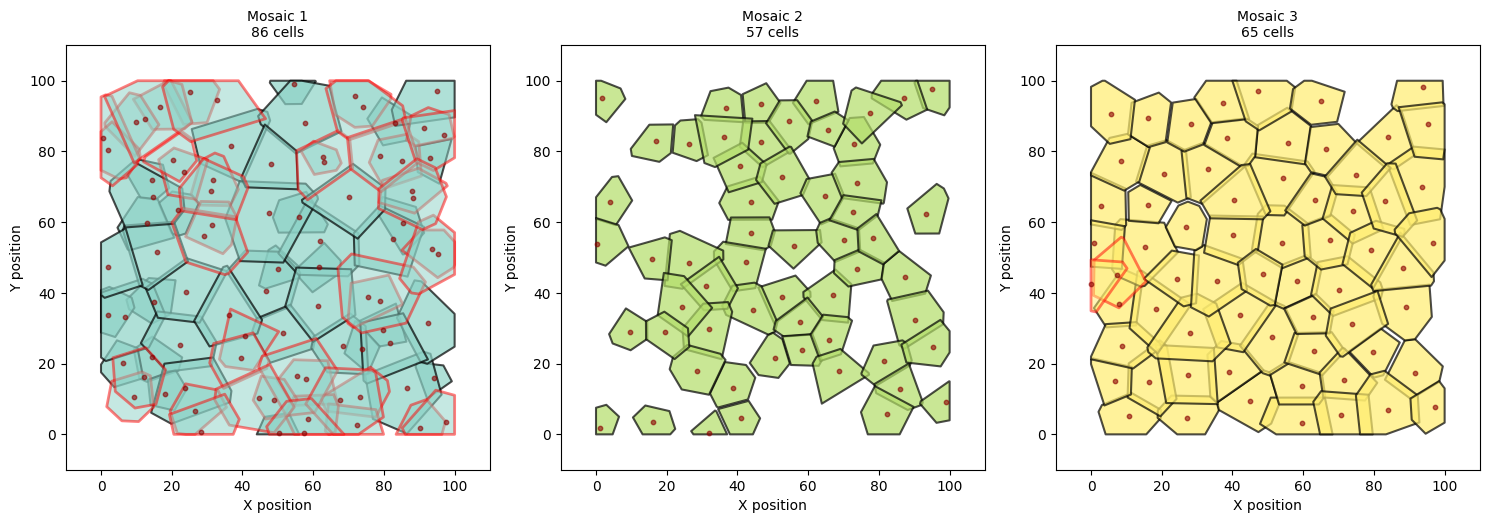

In [19]:
plot_mosaics(adata.obs["leiden_mosaic"], polygons, centers, mode='violations', iou_matrix=iou_matrix,
             iou_threshold=repel_threshold)
plt.show()

In [20]:
from clustering import compare_clustering_mosaic_quality

# 5. Compare mosaic quality
comparison = compare_clustering_mosaic_quality(
    adata,
    iou_matrix,
    standard_key='leiden',
    mosaic_key='leiden_mosaic',
    iou_threshold=repel_threshold,
)

print("\nMosaic Quality Comparison:")
print(comparison.groupby('method')[['mean_iou', 'max_iou', 'violations']].mean())


Mosaic Quality Comparison:
              mean_iou   max_iou  violations
method                                      
Mosaic-aware  0.054866  0.380802         8.0
Standard      0.055532  0.380802         8.0


# Constrained leiden

In [21]:
from constrained_leidenalg import build_feature_knn_graph, find_optimal_resolution, mosaic_leiden_clustering, \
    post_process_enforce_contiguity, analyze_mosaic_quality

features = X
positions = centers

G = build_feature_knn_graph(features, k=5)

overlap_penalty = 10#0.2
overlap_dist = 12

# Find optimal resolution
optimal_res = find_optimal_resolution(
    G, positions,
    target_clusters=(3, 3),
    res_start=0.1,
    res_min=0.001,
    res_max=3.0,
    n_trials=15,
    overlap_dist=overlap_dist,
    overlap_penalty=overlap_penalty,
    n_iterations=10,
    seed=42,
    verbose=True
)

# Run clustering
clusters, partition = mosaic_leiden_clustering(
    G, positions,
    resolution_parameter=optimal_res,
    overlap_dist=overlap_dist,
    overlap_penalty=overlap_penalty,
    n_iterations=10,
    seed=42,
    verbose=True
)

print(f"\nFinal result: {len(np.unique(clusters))} clusters")
cluster_sizes = np.bincount(clusters)
print(f"Cluster sizes: min={cluster_sizes[cluster_sizes > 0].min()}, "
      f"max={cluster_sizes.max()}, "
      f"mean={cluster_sizes[cluster_sizes > 0].mean():.1f}")

# # Optional: enforce contiguity
# clusters_clean = post_process_enforce_contiguity(clusters, positions)
# print(f"After contiguity enforcement: {len(np.unique(clusters_clean))} clusters")
#
# # Analyze quality
# quality = analyze_mosaic_quality(clusters_clean, positions)
# total_overlaps = sum(q['n_overlaps'] for q in quality.values())
# print(f"Total overlapping pairs: {total_overlaps}")

Searching for resolution to get 3-3 clusters...
  Resolution 0.10 -> 5 clusters
  Resolution 0.05 -> 4 clusters
  Resolution 0.03 -> 4 clusters
  Resolution 0.01 -> 3 clusters

✓ Found good resolution: 0.01 gives 3 clusters
Mosaic Leiden Clustering
  Resolution: 0.013375000000000001
  Overlap distance: 12
  Overlap penalty: 10
  Result: 3 clusters

Final result: 3 clusters
Cluster sizes: min=44, max=101, mean=69.3


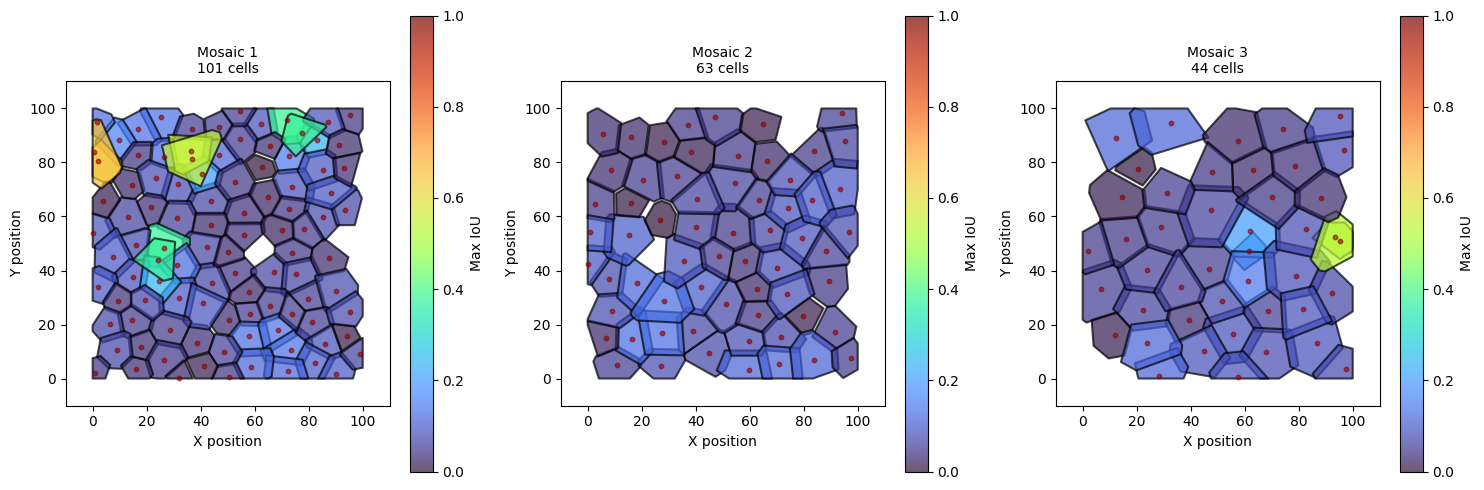

In [22]:
plot_mosaics(clusters, polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()

# Ward

In [23]:
import time
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)

print("Compute structured hierarchical clustering...")
st = time.time()
ward_structured = AgglomerativeClustering(
    n_clusters=3, connectivity=connectivity, linkage="ward"
).fit(X)
elapsed_time_structured = time.time() - st
label_structured = ward_structured.labels_
print(f"Elapsed time: {elapsed_time_structured:.2f}s")
print(f"Number of points: {label_structured.size}")

Compute structured hierarchical clustering...
Elapsed time: 0.01s
Number of points: 208


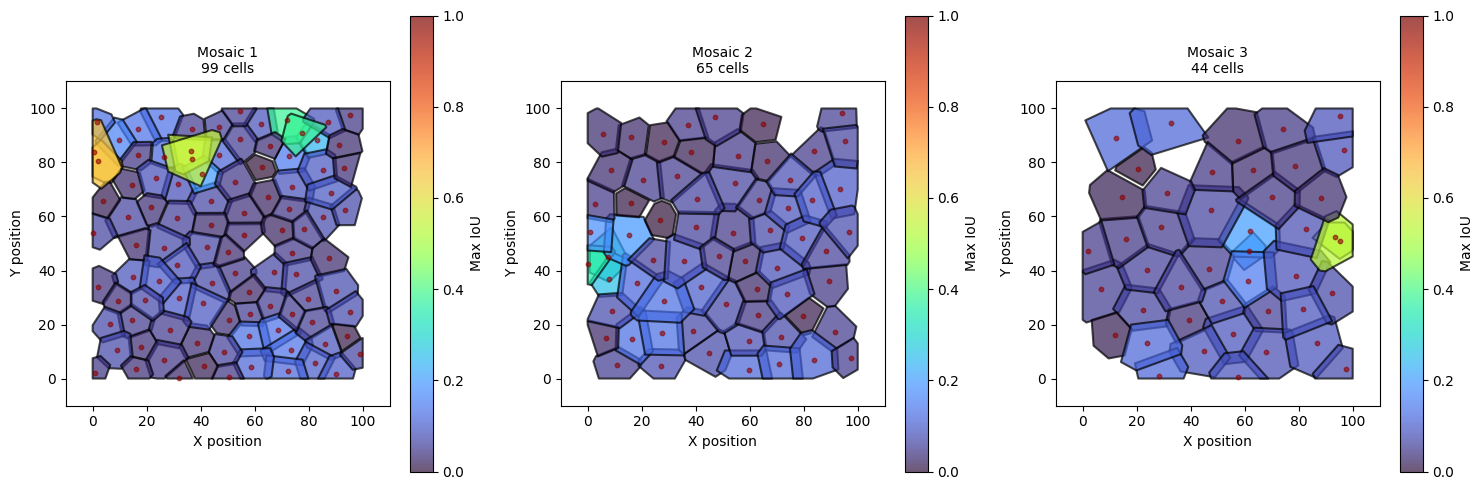

In [24]:
plot_mosaics(label_structured, polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()

# COP k-means

In [26]:
from copkmeans import cop_kmeans

np.random.seed(100)

xs, ys = np.where(iou_matrix > 0.5)
clusters, clust_centers = cop_kmeans(dataset=X, k=3, ml=[], cl=[(int(xi), int(yi)) for xi, yi in zip(xs, ys)])

if not clusters:
    raise ValueError(f"No clusters found")

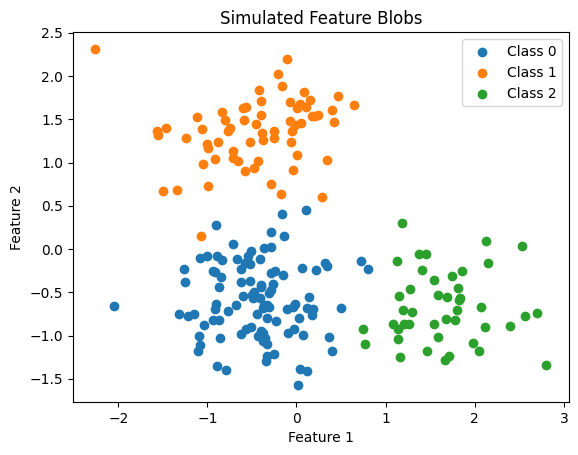

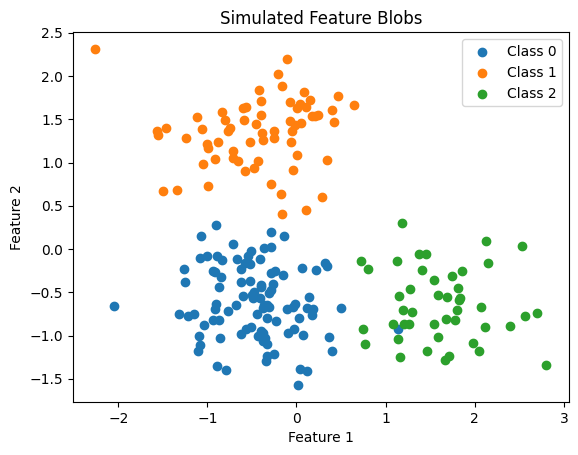

In [27]:
plot_blobs(X=X, y=groups)
plot_blobs(X=X, y=clusters)
plt.show()

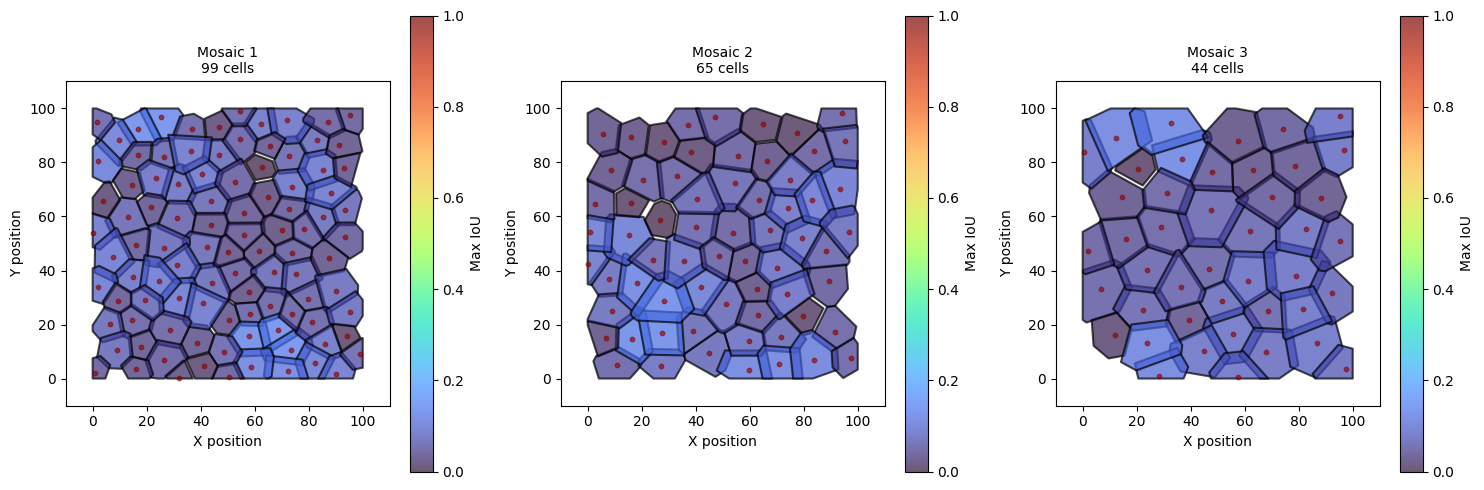

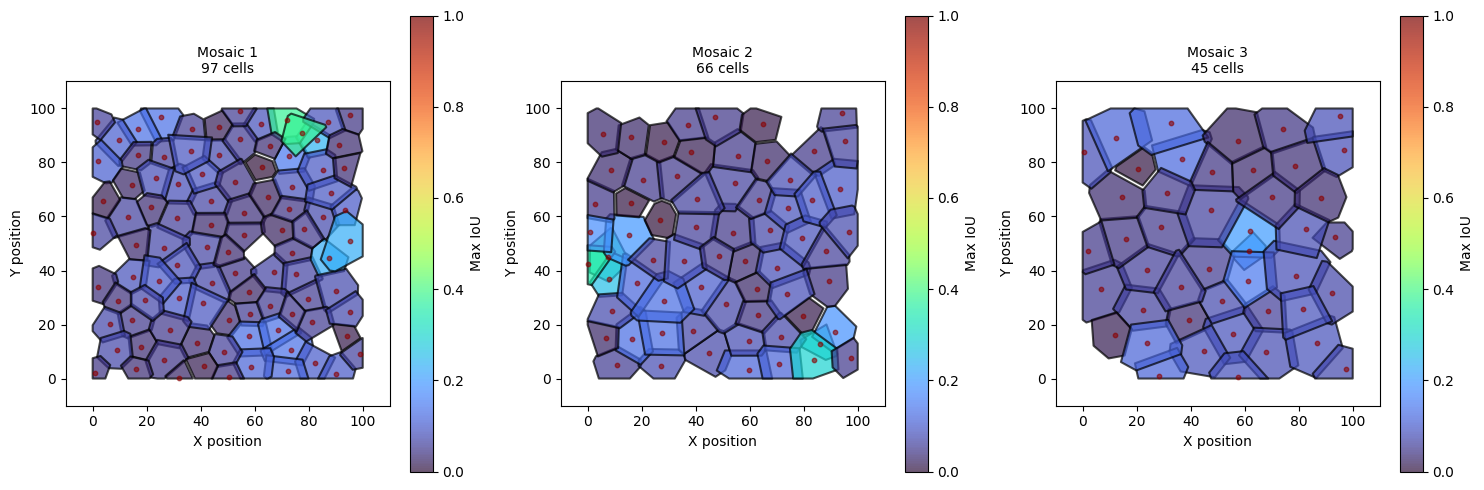

In [28]:
plot_mosaics(groups, polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()

plot_mosaics(np.array(clusters), polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()

# GMM

In [36]:
from gmm import SpatialAwareGMM

gmm_spatial_balanced = SpatialAwareGMM(
    n_components=3,
    covariance_type='full',
    spatial_loss_weight=2.0,
    min_spatial_distance=1.5,
    spatial_inference_weight=3.0,
    additional_loss_fn=None,
    additional_loss_weight=5.0
)
clusters = gmm_spatial_balanced.fit_predict(X, positions)

C:\Users\joesterle\github\jonathanoesterle\toy_mosaics\gmm.py:204: RuntimeWarning: invalid value encountered in log
  np.log(cov_det) +
C:\Users\joesterle\github\jonathanoesterle\toy_mosaics\gmm.py:217: RuntimeWarning: invalid value encountered in reduce
  return np.sum(np.logaddexp.reduce(log_prob, axis=1))
C:\Users\joesterle\github\jonathanoesterle\toy_mosaics\gmm.py:186: RuntimeWarning: overflow encountered in exp
  weights = np.exp(np.append(log_weights, 0))
C:\Users\joesterle\github\jonathanoesterle\toy_mosaics\gmm.py:187: RuntimeWarning: invalid value encountered in divide
  weights /= weights.sum()
C:\Users\joesterle\github\jonathanoesterle\toy_mosaics\gmm.py:215: RuntimeWarning: divide by zero encountered in log
  log_prob[:, k] += np.log(weights[k])


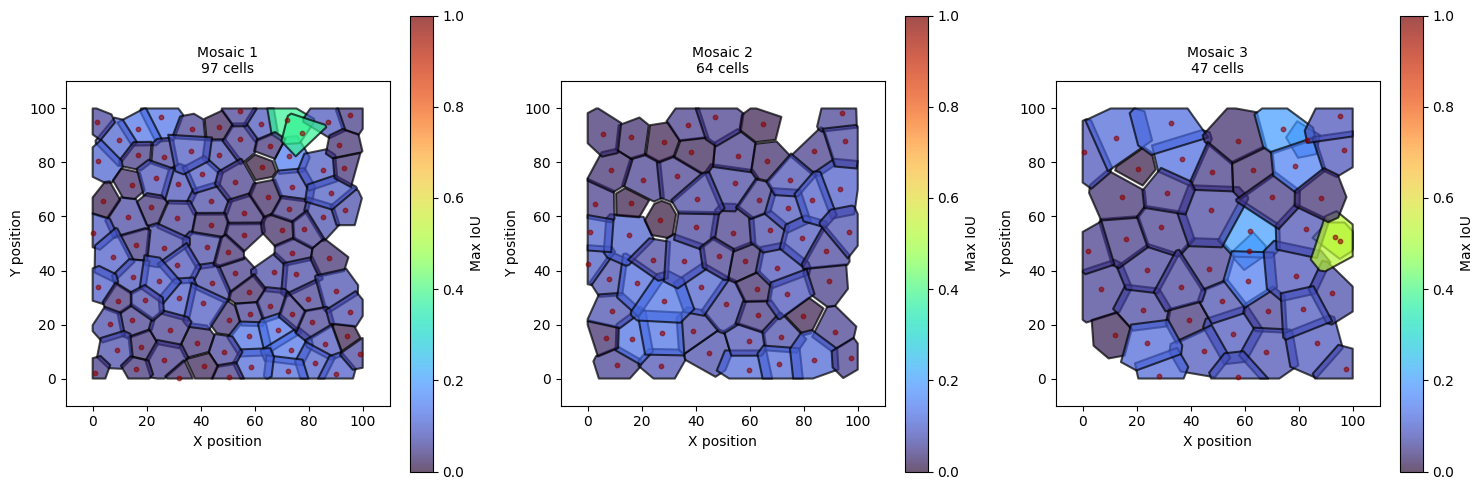

In [37]:
plot_mosaics(clusters, polygons, centers, mode='iou', iou_matrix=iou_matrix)
plt.show()